<a href="https://colab.research.google.com/github/politeles/audio_classification/blob/main/VADS_yamnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning to train a Yammnet classifier for the VADS dataset

 We are going to load the dataset and the initial model.

In [ ]:
%pip install --upgrade tensorflow==2.17
%pip install -q tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow-io[tensorflow]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-

In [ ]:
%pip install --upgrade tensorflow-datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 19.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.9.6
    Uninstalling tensorflow-datasets-4.9.6:
      Successfully uninstalled tensorflow-datasets-4.9.6


In [ ]:
!pip install datasets[audio]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 19.0.1 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 19.0.1 which is incompatible.


In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [ ]:
import librosa

In [ ]:
# Set seed for experiment reproducibility
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
from datasets import load_dataset

In [ ]:
vads = load_dataset("politeles/vads")

README.md:   0%|          | 0.00/4.90k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2515 [00:00<?, ? examples/s]

In [ ]:
audio_sample = vads['train']['audio'][0]['array']

In [ ]:
id2label_fn = vads["train"].features["technique"].int2str

In [ ]:
for label in range(0,9):
  print('Technique: '+str(label)+' value: '+str(id2label_fn(label)))

Technique: 0 value: bariolage
Technique: 1 value: chords
Technique: 2 value: doublestops
Technique: 3 value: legato
Technique: 4 value: martele
Technique: 5 value: pizz
Technique: 6 value: ricochet
Technique: 7 value: spicatto
Technique: 8 value: sulponticello


In [ ]:
audio_sample

array([-0.01071167, -0.01193237, -0.01132202, ...,  0.0479126 ,
       -0.03659058, -0.10913086])

In [ ]:
sr = vads['train']['audio'][0]['sampling_rate']

In [ ]:
vads['train']['audio'][0]

{'path': 'bariolage1_sample-0.wav',
 'array': array([-0.01071167, -0.01193237, -0.01132202, ...,  0.0479126 ,
        -0.03659058, -0.10913086]),
 'sampling_rate': 48000}

In [ ]:
wav = librosa.resample(audio_sample,orig_sr=sr,target_sr=16000)

In [ ]:
wav

array([-0.00738981, -0.01287119, -0.01104051, ...,  0.10692932,
        0.18936762,  0.03587643])

In [ ]:
display.Audio(wav, rate=16000)

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')


Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [ ]:
scores, embeddings, spectrogram = yamnet_model(wav)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Music
The embeddings shape: (2, 1024)


In [ ]:
def load_audio_from_hf_dataset(example, desired_sample_rate, desired_channels):
  """Loads audio from a Hugging Face dataset example.

  Args:
    example: A dictionary representing a single example from the Hugging Face dataset.
    desired_sample_rate: The desired sample rate for the audio.
    desired_channels: The desired number of channels (1 for mono, 2 for stereo).

  Returns:
    A TensorFlow tensor containing the resampled audio waveform.
  """

  # Access audio data and sample rate from the Hugging Face dataset example
  audio_data = example['audio']['array']  # Assuming 'audio' key contains audio data
  sample_rate = example['audio']['sampling_rate'] # Assuming 'sampling_rate' key


  # Convert audio data to TensorFlow tensor
  y = librosa.resample(audio_data,orig_sr=sr,target_sr=desired_sample_rate)
  wav = tf.convert_to_tensor(y, dtype=tf.float32)



  return wav

In [ ]:
# write audio files resampled to disk
def write_audio_to_disk(example, desired_sample_rate, desired_channels):
  file_name = example['audio']['path']
  audio_data = example['audio']['array']  # Assuming 'audio' key contains audio data
  sample_rate = example['audio']['sampling_rate'] # Assuming 'sampling_rate' k
  y = librosa.resample(audio_data,orig_sr=sr,target_sr=desired_sample_rate)
  #write to disk the audio example

## Plot an audio example

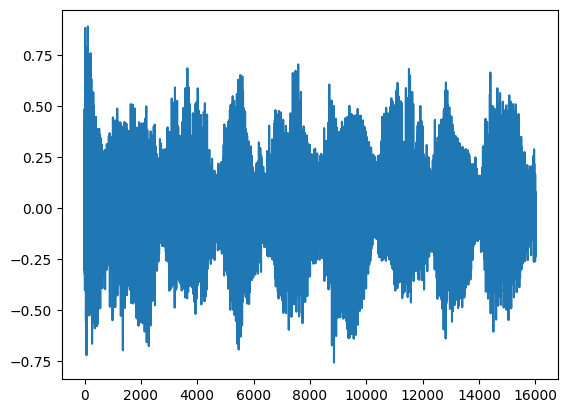

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

sample_rate = 16000
channels = 1

test_wav_file_path = vads['train'][60]
test_wav_data = load_audio_from_hf_dataset(test_wav_file_path, sample_rate, channels)

plt.plot(test_wav_data)
plt.show()

display.Audio(test_wav_data, rate=sample_rate)

In [ ]:
test_wav_data

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-0.3011727 ,  0.00376597,  0.48422283, ..., -0.23853122,
       -0.13462968,  0.07807195], dtype=float32)>

In [ ]:
# Rename the "technique" column to "label"
vads = vads.rename_column("technique", "label")

In [ ]:
vads = vads.remove_columns(["microphone","string","note"])

In [ ]:
vads_train_test = vads['train'].train_test_split(test_size=0.2)  # split the dataset


In [ ]:
vads['train'][0]['audio']

{'path': 'bariolage1_sample-0.wav',
 'array': array([-0.01071167, -0.01193237, -0.01132202, ...,  0.0479126 ,
        -0.03659058, -0.10913086]),
 'sampling_rate': 48000}

In [ ]:
# get the total number of classes:
num_classes = len(vads['train'].unique('label'))

In [ ]:
num_classes

9

In [ ]:
# Preprocess the data
def preprocess_function(example):
    audio = load_audio_from_hf_dataset(example, desired_sample_rate=16000, desired_channels=1)
    label = example["label"]
    #label_one_hot = tf.one_hot(label,num_classes)
    return {"audio": audio, "label": label}

In [ ]:
# Apply the preprocessing function to the dataset
vads_train_test_preprocessed = vads_train_test.map(preprocess_function)

Map:   0%|          | 0/2012 [00:00<?, ? examples/s]

Map:   0%|          | 0/503 [00:00<?, ? examples/s]

In [ ]:
vads_train_test_preprocessed

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 2012
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 503
    })
})

In [ ]:
wav_sample1 = vads_train_test_preprocessed['train'][0]['audio']

In [ ]:
display.Audio(wav_sample1, rate=16000)

In [ ]:
tf_train_ds = vads_train_test_preprocessed['train'].with_format("tf")

In [ ]:
tf_test_ds = vads_train_test_preprocessed['test'].with_format("tf")

In [ ]:
#tf_train_ds[0]

In [ ]:
type(tf_train_ds)

datasets.arrow_dataset.Dataset

In [ ]:
# Now you can create the TensorFlow Datasets
#train_ds = vads_train_test_preprocessed['train'].to_tf_dataset(
#    columns=["audio", "label"],  # Now just specify the column names
   # batch_size=32,
   # shuffle=True,
#    label_cols="label",
#)

In [ ]:
#train_ds.element_spec

In [ ]:
#test_ds = vads_train_test_preprocessed['test'].to_tf_dataset(
#    columns=["audio", "label"],  # Now just specify the column names
 #   batch_size=32,
 #   shuffle=False,
#    label_cols="label",
#)

In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(features):
  ''' run YAMNet to extract embedding from the wav data '''
  wav_data = features['audio']
  label = features['label']
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  # Select the first embedding
  embeddings = embeddings[0]

  # Repeat the label for each embedding
  #repeated_label = tf.repeat(label, num_embeddings, axis=0)

  # Create a dictionary with repeated embeddings and labels
  return {'embeddings': embeddings, 'label': label}

In [ ]:
extract_embedding(tf_train_ds[5])

{'embeddings': <tf.Tensor: shape=(1024,), dtype=float32, numpy=
 array([0.        , 0.        , 0.        , ..., 0.04172736, 0.        ,
        0.        ], dtype=float32)>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>}

In [ ]:
tf_train_dataset = tf_train_ds.map(extract_embedding,remove_columns=tf_train_ds.column_names)

#train_ds_pr.element_spec
#tensor_embeddings = []
#tensor_labels = []
#for element in tf_train_ds:
#  embedding, label = extract_embedding(element)
#  tensor_embeddings.append(embedding)
#  tensor_labels.append(label)

Parameter 'function'=<function extract_embedding at 0x7fa7f03e2f80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/2012 [00:00<?, ? examples/s]

In [ ]:
# flatten and unbatch the data
#tf_train_dataset = tf_train_dataset.with_format("tf").flat_map(lambda x: tf.data.Dataset.from_tensor_slices((x['embeddings'], x['label']))).unbatch()

In [ ]:
#train_ds_pr = (tensor_embeddings,tensor_labels)

In [ ]:
tf_train_dataset[0]

{'label': <tf.Tensor: shape=(), dtype=int64, numpy=6>,
 'embeddings': <tf.Tensor: shape=(1024,), dtype=float32, numpy=
 array([0.        , 0.        , 0.        , ..., 0.03743266, 0.        ,
        0.        ], dtype=float32)>}

In [ ]:
tf_train_dataset = tf_train_dataset.to_tf_dataset(columns=['embeddings','label'],batch_size=32)

In [ ]:
tf_train_dataset.element_spec

{'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'embeddings': TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None)}

In [ ]:
tf_train_dataset = tf_train_dataset.map(lambda x: (x['embeddings'],x['label']))

In [ ]:
tf_train_dataset.element_spec

(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
#train_ds_pr = train_ds_pr.remove_columns('audio')

In [ ]:
tf_test_dataset = tf_test_ds.map(extract_embedding,remove_columns=tf_test_ds.column_names)
#test_ds_pr.element_spec
#test_tensor_embeddings = []
#test_tensor_labels = []
#for element in tf_test_ds:
#  embedding, label = extract_embedding(element)
#  test_tensor_embeddings.append(embedding)
#  test_tensor_labels.append(label)

Map:   0%|          | 0/503 [00:00<?, ? examples/s]

In [ ]:
tf_test_dataset = tf_test_dataset.to_tf_dataset(columns=['embeddings','label'],batch_size=32)

In [ ]:
tf_test_dataset = tf_test_dataset.map(lambda x: (x['embeddings'],x['label']))

In [ ]:
#test_ds_pr = (test_tensor_embeddings,test_tensor_labels)

In [ ]:
#test_ds_pr = test_ds_pr.remove_columns('audio')

# Own model

In [ ]:
my_classes = vads['train'].features['label'].num_classes

In [ ]:
#tf_train_dataset = train_ds_pr.to_tf_dataset(columns=['embeddings','label'],batch_size=32)
tf_train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
tf_train_dataset.element_spec

(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
#tf_test_dataset = test_ds_pr.to_tf_dataset(columns=['embeddings','label'],batch_size=32)
#tf_test_dataset = tf.data.Dataset.from_tensor_slices(test_ds_pr)

In [ ]:
tf_test_dataset.element_spec

(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
regularization = 0.03
num_hidden = 64 # or 512
activation = 'softmax' # or 'relu'
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(num_hidden, activation=None, kernel_regularizer=tf.keras.regularizers.l2(regularization)),
    tf.keras.layers.Dense(my_classes,activation=activation)
], name='my_model')

my_model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,185 (258.54 KB)

 Trainable params: 66,185 (258.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

#callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
#                                           patience=3,
#                                          restore_best_weights=True)

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./violin_y.keras', monitor='val_loss', save_best_only=True),
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=15, verbose=1,
                                                      min_lr=0.000001)]

In [ ]:
history = my_model.fit(tf_train_dataset,
                       epochs=250,
                       validation_data=tf_test_dataset,
                       callbacks=callbacks)

Epoch 1/250
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9088 - loss: 0.4337 - val_accuracy: 0.8787 - val_loss: 0.5125 - learning_rate: 0.0010
Epoch 2/250
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9105 - loss: 0.4333 - val_accuracy: 0.8787 - val_loss: 0.4997 - learning_rate: 0.0010
Epoch 3/250
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9128 - loss: 0.4268 - val_accuracy: 0.8767 - val_loss: 0.5044 - learning_rate: 0.0010
Epoch 4/250
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9143 - loss: 0.4254 - val_accuracy: 0.8767 - val_loss: 0.4964 - learning_rate: 0.0010
Epoch 5/250
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9142 - loss: 0.4211 - val_accuracy: 0.8767 - val_loss: 0.5039 - learning_rate: 0.0010
Epoch 6/250
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9143 - loss: 0.4206 - val_accuracy: 0.8787 - val_loss: 0.4929 - learning_rate: 0.0010
Epoch 7/250
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9157 - loss: 0.4152 - val_acc

In [ ]:
#for element in tf_train_dataset:
#  if element['embeddings'] is None:
#           print(element)
#  if element['label'] is None:
#           print(element)

In [ ]:
#classification test
scores, embeddings, spectrogram = yamnet_model(wav)
scores= my_model(embeddings)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = top_class

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: 0
The embeddings shape: (2, 1024)


In [ ]:
class_scores

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([9.6708250e-01, 2.0603109e-03, 2.6260003e-02, 5.3142506e-04,
       3.0872603e-03, 6.4755914e-05, 4.8462785e-04, 4.6406727e-05,
       3.8272777e-04], dtype=float32)>

In [ ]:
id2label_fn = vads["train"].features["label"].int2str

KeyError: 'label'

In [ ]:
id2label_fn(6)

'ricochet'

# Save a model that can directly take a WAV file as input

Your model works when you give it the embeddings as input.

In a real-world scenario, you'll want to use audio data as a direct input.

To do that, you will combine YAMNet with your model into a single model that you can export for other applications.

To make it easier to use the model's result, the final layer will be a reduce_mean operation. When using this model for serving (which you will learn about later in the tutorial), you will need the name of the final layer. If you don't define one, TensorFlow will auto-define an incremental one that makes it hard to test, as it will keep changing every time you train the model. When using a raw TensorFlow operation, you can't assign a name to it. To address this issue, you'll create a custom layer that applies reduce_mean and call it 'classifier'.

In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [ ]:
class YamnetLayer(tf.keras.layers.Layer):
    def __init__(self, yamnet_model_handle, **kwargs):
        super(YamnetLayer, self).__init__(**kwargs)
        self.yamnet_model = hub.KerasLayer(yamnet_model_handle, trainable=False)

    def call(self, inputs):
        # The input to the Yamnet layer should be a Tensor, not a KerasTensor
        # This conversion happens automatically during execution
        _, embeddings_output, _ = self.yamnet_model(inputs)
        return embeddings_output

In [ ]:
saved_model_path = './violin_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
yamnet_layer = YamnetLayer(yamnet_model_handle)
# Pass the input_segment to the YamnetLayer
embeddings_output = yamnet_layer(input_segment)

serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)


In [ ]:
serving_model.export(saved_model_path)

Saved artifact at './violin_yamnet'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.float32, name='audio')
Output Type:
  TensorSpec(shape=(9,), dtype=tf.float32, name=None)
Captures:
  140355713139456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140355713203392: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  140355713139104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140355713138752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140355713203744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140355713203216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140355713201808: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  140355713202864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140355713202512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140355713202160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140355713201632: TensorSpec(shape=(

In [ ]:
#tf.saved_model.save(serving_model, saved_model_path)

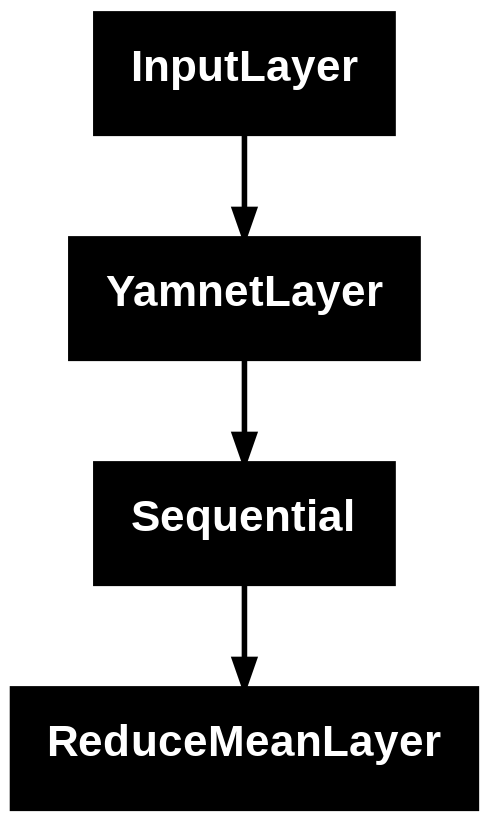

In [ ]:
tf.keras.utils.plot_model(serving_model)

In [ ]:
serving_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ audio (InputLayer)                   │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ yamnet_layer_1 (YamnetLayer)         │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_model (Sequential)                │ (None, 9)                   │          66,185 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classifier (ReduceMeanLayer)         │ (9)                         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,185 (258.54 KB)

 Trainable params: 66,185 (258.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
reloaded_results= reloaded_model.signatures["serving_default"](tf.convert_to_tensor(wav,dtype=tf.float32))

In [ ]:
reloaded_results

{'output_0': <tf.Tensor: shape=(9,), dtype=float32, numpy=
 array([9.6708250e-01, 2.0603109e-03, 2.6260003e-02, 5.3142506e-04,
        3.0872603e-03, 6.4755914e-05, 4.8462785e-04, 4.6406727e-05,
        3.8272777e-04], dtype=float32)>}

In [ ]:
top_class = np.argmax(reloaded_results)
inferred_class = top_class

In [ ]:
inferred_class

0

# Optimizing the model

In [ ]:
import tensorflow_model_optimization as tfmot

In [ ]:
def apply_qat_to_dense_and_cnn(layer):
  if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer




In [ ]:
annotated_model = tf.keras.models.clone_model(
    serving_model,
    clone_function=apply_qat_to_dense_and_cnn,
)


In [ ]:
annotated_model

<Functional name=functional_1, built=True>

In [ ]:
#quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
#quant_aware_model.summary()

# Save the model in tflite format

In [ ]:
#converter = tf.lite.TFLiteConverter.from_keras_model(serving_model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
#def representative_data_gen():
#  for input_value, output_value in tf_train_dataset.unbatch().batch(1).take(100):
#    # Model has only one input so each data point has one element.
#    yield [input_value]

In [ ]:
#converter.representative_dataset = representative_data_gen

In [ ]:
# Ensure that if any ops can't be quantized, the converter throws an error
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

In [ ]:
# Set the input and output tensors to uint8 (APIs added in r2.3)
#converter.inference_input_type = tf.float32
#converter.inference_output_type = tf.int8
#tflite_model_quant = converter.convert()

#with open("tflite_model.tflite", "wb") as f:
#  f.write(tflite_model_quant)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

In [ ]:
tf_lite_model = converter.convert()

In [ ]:
with open('violin.tflite','wb') as f:
  f.write(tf_lite_model)

In [ ]:
# Check the model
interpreter = tf.lite.Interpreter('violin.tflite')

In [ ]:
audio_input_index = interpreter.get_input_details()[0]['index']

In [ ]:
scores_output_index = interpreter.get_output_details()[0]['index']

In [ ]:
embeddings_output_index = interpreter.get_output_details()[1]['index']

IndexError: list index out of range

In [ ]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall_1:0',
  'index': 195,
  'shape': array([9], dtype=int32),
  'shape_signature': array([9], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
# Check the model
interpreter = tf.lite.Interpreter('yamnet.tflite')

In [ ]:
audio_input_index = interpreter.get_input_details()[0]['index']

In [ ]:
audio_input_index

0

In [ ]:
scores_output_index = interpreter.get_output_details()[0]['index']

In [ ]:
scores_output_index

120

In [ ]:
interpreter.get_output_details()

[{'name': 'tower0/network/layer32/final_output',
  'index': 120,
  'shape': array([  1, 521], dtype=int32),
  'shape_signature': array([  1, 521], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
embeddings_output_index = interpreter.get_output_details()[1]['index']

IndexError: list index out of range

In [ ]:
!pip install tflite-support

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 21.0 MB/s eta 0:00:00


In [ ]:
from tflite_support.metadata_writers import audio_classifier

ImportError: generic_type: cannot initialize type "StatusCode": an object with that name is already defined

In [ ]:
platform.system()

NameError: name 'platform' is not defined